# Prophet on Total Sales (Units Sold) with Explanatory Variables

In [ ]:
import pandas as pd
from prophet import Prophet
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
import itertools
%matplotlib inline

In [21]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [22]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    
    smape = 100 * np.mean(numerator / (denominator + 1e-10 ))
    return smape

In [23]:
df = pd.read_csv('../dataset/clustered_data.csv')

In [24]:
total_df = df.groupby('Date')[['UnitsSold', 'AveragePricePerUnitPounds']].sum().reset_index()

In [25]:
total_df['lag_1'] = total_df['UnitsSold'].shift(1)
total_df['lag_7'] = total_df['UnitsSold'].shift(7)
total_df['lag_14'] = total_df['UnitsSold'].shift(14)

total_df['Rolling_Mean_7'] = total_df['UnitsSold'].rolling(window=7).mean()
total_df['Rolling_Std_7'] = total_df['UnitsSold'].rolling(window=7).std()

In [26]:
total_df['lag_1'] = total_df['lag_1'].ffill()
total_df['lag_7'] = total_df['lag_7'].ffill()
total_df['lag_14'] = total_df['lag_14'].ffill()

total_df['Rolling_Mean_7'] = total_df['Rolling_Mean_7'].fillna(total_df['UnitsSold'].expanding().mean())

total_df['Rolling_Std_7'] = total_df['Rolling_Std_7'].fillna(total_df['UnitsSold'].expanding().std().fillna(0))


In [27]:
total_df = total_df.rename(columns={'Date': 'date', 'UnitsSold': "y"})

In [28]:
explanatory_df = pd.read_csv('../explanatory_variables/combined_explanatory_variables.csv')

In [29]:
total_df = total_df.merge(explanatory_df, on='date', how='left')

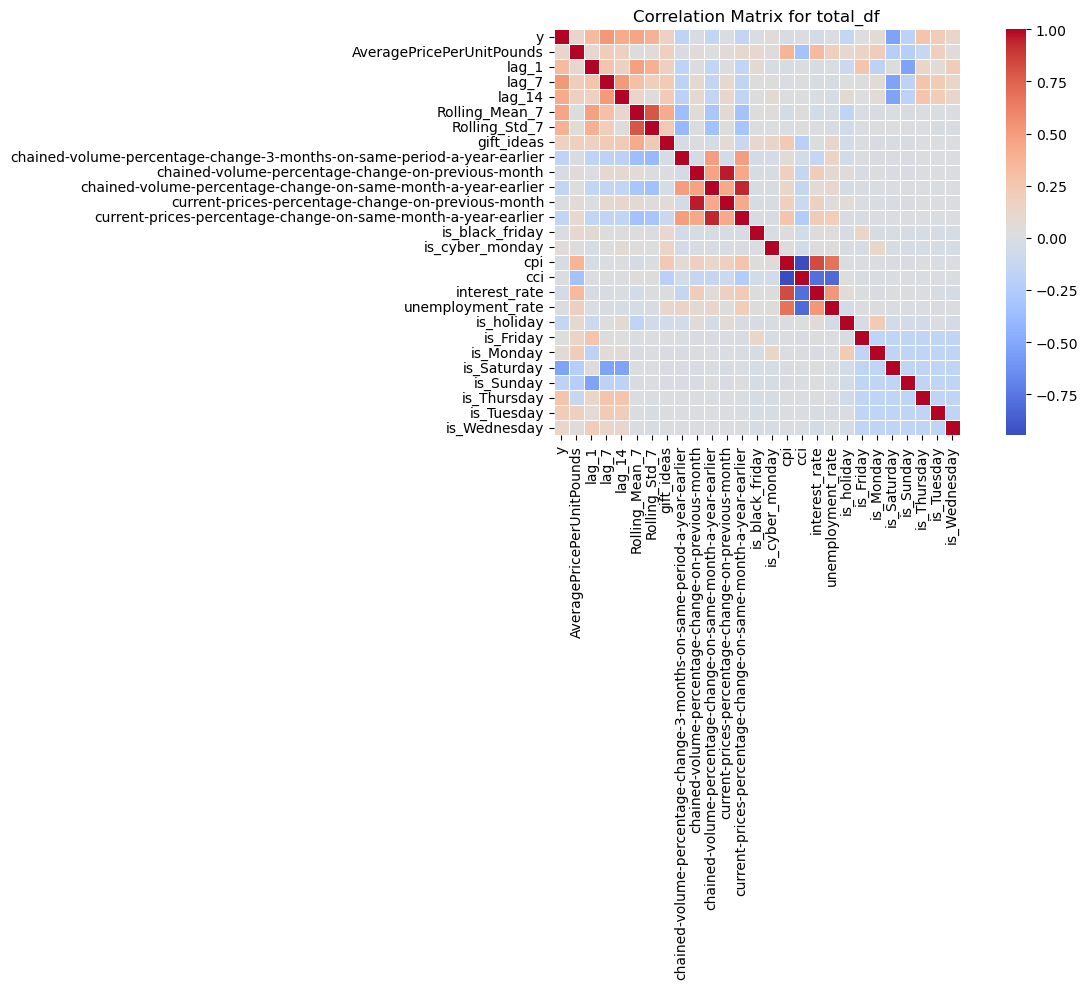

In [30]:
bool_cols = total_df.select_dtypes(include='bool').columns
total_df[bool_cols] = total_df[bool_cols].astype(int)

corr_matrix = total_df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix for total_df")
plt.tight_layout()
plt.show()

In [31]:
y_corr = corr_matrix['y'].drop('y').sort_values(ascending=False)
y_corr

lag_7                                                                      0.513879
Rolling_Mean_7                                                             0.456164
lag_14                                                                     0.423921
Rolling_Std_7                                                              0.384624
lag_1                                                                      0.338336
is_Thursday                                                                0.272283
is_Tuesday                                                                 0.216020
gift_ideas                                                                 0.168698
is_Wednesday                                                               0.130041
AveragePricePerUnitPounds                                                  0.118940
is_Monday                                                                  0.067264
is_cyber_monday                                                            0

In [32]:
total_df = total_df.rename(columns={'date': 'ds'})
total_df['ds'] = pd.to_datetime(total_df['ds'])

In [33]:
# regressors = ['AveragePricePerUnitPounds', 'gift_ideas',
#        'chained-volume-percentage-change-3-months-on-same-period-a-year-earlier',
#        'chained-volume-percentage-change-on-previous-month',
#        'chained-volume-percentage-change-on-same-month-a-year-earlier',
#        'current-prices-percentage-change-on-previous-month',
#        'current-prices-percentage-change-on-same-month-a-year-earlier',
#        'is_black_friday', 'is_cyber_monday', 'cpi', 'cci', 'interest_rate',
#        'unemployment_rate', 'is_holiday', 'is_Friday', 'is_Monday',
#        'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday',
#        'is_Wednesday', 'lag_1',
#        'lag_7',
#        'lag_14',
#        'Rolling_Mean_7',
#        'Rolling_Std_7']

regressors = ['lag_7',
       'Rolling_Mean_7',
       'lag_14',
       'Rolling_Std_7',
       'lag_1',
       'is_Thursday',
       'is_Tuesday']

total_df[regressors] = total_df[regressors].ffill().bfill()

In [34]:
n = len(total_df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_data = total_df.iloc[:train_end]
validation_data = total_df.iloc[train_end:val_end]
test_data = total_df.iloc[val_end:]

In [35]:
clip_threshold = np.percentile(total_df['y'], 99)

In [36]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

for reg in regressors:
    model.add_regressor(reg)
    
model.fit(train_data)

22:33:45 - cmdstanpy - INFO - Chain [1] start processing
22:33:46 - cmdstanpy - INFO - Chain [1] done processing


## Validation

In [37]:
validation_forecast = model.predict(validation_data)

In [38]:
actual_values = np.array(validation_data['y'])
predicted_values = np.array(validation_forecast['yhat'])

In [39]:
validation_smape = calculate_smape(actual_values, predicted_values)
validation_smape

30.267672445368476

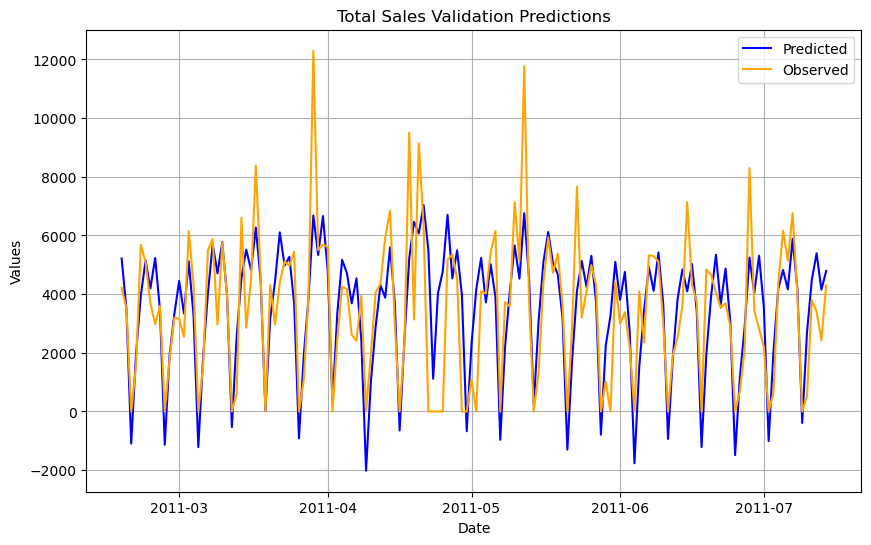

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(validation_data['ds']), validation_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(validation_data['ds']), validation_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Validation Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [41]:
test_forecast = model.predict(test_data)

In [42]:
actual_values = np.array(test_data['y'])
predicted_values = np.array(test_forecast['yhat'])

In [43]:
test_smape = calculate_smape(actual_values, predicted_values)
test_smape

29.057476309539272

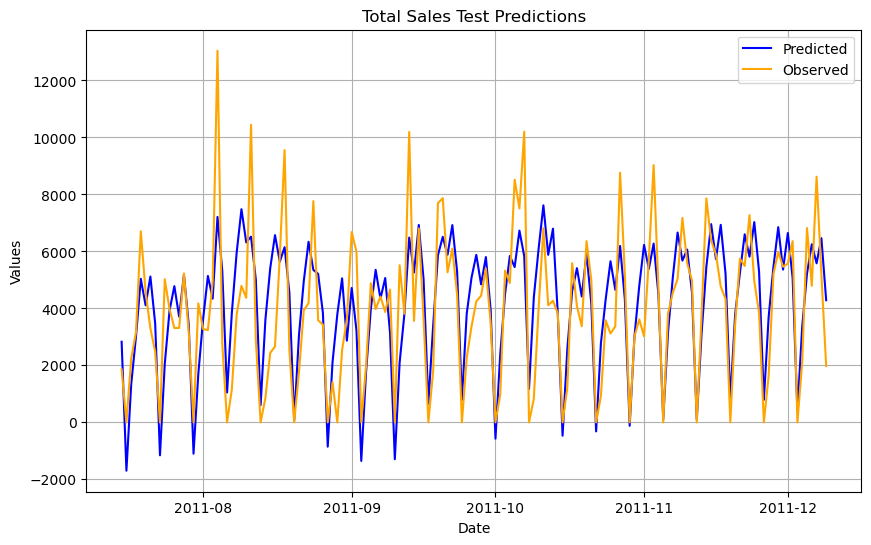

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Overall

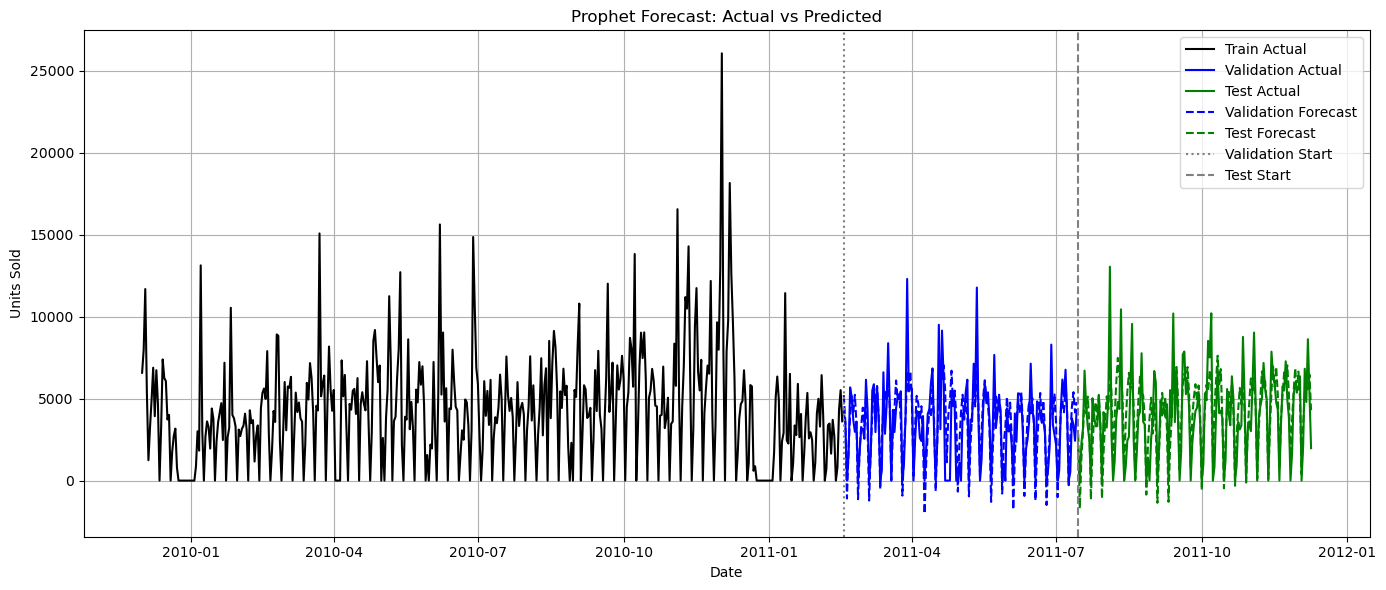

In [45]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(validation_forecast['ds'], validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Tuning

In [46]:
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "seasonality_prior_scale": [0.05, 0.1, 0.5, 1, 5],
    "fourier_order": [3, 5, 10]
}

best_smape = float("inf")
best_params = None
best_model = None

In [47]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
validation_data = validation_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

In [48]:
# Grid search loop
for cps, sps, fo in itertools.product(
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"],
    param_grid["fourier_order"]
):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps
    )

    # Add custom monthly seasonality
    model.add_seasonality(name="monthly", period=30.5, fourier_order=fo)

    for reg in regressors:
        model.add_regressor(reg)

    try:
        # Fit model
        model.fit(train_data)

        # Predict on test
        future = validation_data[['ds'] + regressors]
        forecast = model.predict(future)

        # Evaluate
        y_true = validation_data["y"]
        y_pred = np.clip(forecast["yhat"], 0, clip_threshold)

        smape = calculate_smape(y_true, y_pred)

        print(f"cps={cps}, sps={sps}, fo={fo}: SMAPE={smape:.2f}%")

        if smape < best_smape:
            best_smape = smape
            best_params = (cps, sps, fo)
            best_model = model

    except Exception as e:
        print(f"⚠️ Skipping params (cps={cps}, sps={sps}, fo={fo}) due to error: {e}")

22:33:53 - cmdstanpy - INFO - Chain [1] start processing
22:33:53 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=3: SMAPE=18.53%


22:33:54 - cmdstanpy - INFO - Chain [1] start processing
22:33:54 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=5: SMAPE=18.38%


22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=10: SMAPE=19.30%


22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:57 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.1, fo=3: SMAPE=16.97%


22:33:58 - cmdstanpy - INFO - Chain [1] start processing
22:33:58 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.1, fo=5: SMAPE=17.01%


22:34:00 - cmdstanpy - INFO - Chain [1] start processing
22:34:00 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.1, fo=10: SMAPE=19.39%


22:34:01 - cmdstanpy - INFO - Chain [1] start processing
22:34:01 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=3: SMAPE=16.96%


22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=5: SMAPE=18.47%


22:34:03 - cmdstanpy - INFO - Chain [1] start processing
22:34:04 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=10: SMAPE=19.48%


22:34:05 - cmdstanpy - INFO - Chain [1] start processing
22:34:05 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=3: SMAPE=16.96%


22:34:06 - cmdstanpy - INFO - Chain [1] start processing
22:34:06 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=5: SMAPE=17.73%


22:34:08 - cmdstanpy - INFO - Chain [1] start processing
22:34:08 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=10: SMAPE=19.50%


22:34:09 - cmdstanpy - INFO - Chain [1] start processing
22:34:09 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=3: SMAPE=16.95%


22:34:10 - cmdstanpy - INFO - Chain [1] start processing
22:34:11 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=5: SMAPE=16.98%


22:34:12 - cmdstanpy - INFO - Chain [1] start processing
22:34:12 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=10: SMAPE=19.33%


22:34:13 - cmdstanpy - INFO - Chain [1] start processing
22:34:13 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=3: SMAPE=18.37%


22:34:14 - cmdstanpy - INFO - Chain [1] start processing
22:34:15 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=5: SMAPE=18.38%


22:34:16 - cmdstanpy - INFO - Chain [1] start processing
22:34:16 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=10: SMAPE=19.29%


22:34:17 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=3: SMAPE=17.06%


22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:19 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=5: SMAPE=18.35%


22:34:20 - cmdstanpy - INFO - Chain [1] start processing
22:34:20 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=10: SMAPE=18.61%


22:34:21 - cmdstanpy - INFO - Chain [1] start processing
22:34:21 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=3: SMAPE=17.81%


22:34:22 - cmdstanpy - INFO - Chain [1] start processing
22:34:22 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=5: SMAPE=18.49%


22:34:23 - cmdstanpy - INFO - Chain [1] start processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=10: SMAPE=18.65%


22:34:23 - cmdstanpy - INFO - Chain [1] start processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=3: SMAPE=17.07%


22:34:24 - cmdstanpy - INFO - Chain [1] start processing
22:34:24 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=5: SMAPE=18.51%


22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=10: SMAPE=18.62%


22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:26 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=5, fo=3: SMAPE=17.08%


22:34:26 - cmdstanpy - INFO - Chain [1] start processing
22:34:26 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=5, fo=5: SMAPE=18.45%


22:34:27 - cmdstanpy - INFO - Chain [1] start processing
22:34:27 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=5, fo=10: SMAPE=19.44%


22:34:28 - cmdstanpy - INFO - Chain [1] start processing
22:34:28 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=3: SMAPE=18.39%


22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=5: SMAPE=18.41%


22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=10: SMAPE=19.34%


22:34:30 - cmdstanpy - INFO - Chain [1] start processing
22:34:30 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=3: SMAPE=17.02%


22:34:30 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=5: SMAPE=18.38%


22:34:31 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=10: SMAPE=18.63%


22:34:32 - cmdstanpy - INFO - Chain [1] start processing
22:34:32 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.5, fo=3: SMAPE=17.04%


22:34:32 - cmdstanpy - INFO - Chain [1] start processing
22:34:32 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.5, fo=5: SMAPE=18.42%


22:34:33 - cmdstanpy - INFO - Chain [1] start processing
22:34:33 - cmdstanpy - INFO - Chain [1] done processing
22:34:33 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.5, fo=10: SMAPE=18.66%


22:34:33 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1, fo=3: SMAPE=17.76%


22:34:34 - cmdstanpy - INFO - Chain [1] start processing
22:34:34 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1, fo=5: SMAPE=18.40%


22:34:34 - cmdstanpy - INFO - Chain [1] start processing
22:34:34 - cmdstanpy - INFO - Chain [1] done processing
22:34:35 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=1, fo=10: SMAPE=18.65%


22:34:35 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=3: SMAPE=17.06%


22:34:36 - cmdstanpy - INFO - Chain [1] start processing
22:34:36 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=5: SMAPE=17.70%


22:34:37 - cmdstanpy - INFO - Chain [1] start processing
22:34:37 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=10: SMAPE=18.67%


22:34:39 - cmdstanpy - INFO - Chain [1] start processing
22:34:39 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.05, fo=3: SMAPE=18.37%


22:34:40 - cmdstanpy - INFO - Chain [1] start processing
22:34:41 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.05, fo=5: SMAPE=18.37%


22:34:41 - cmdstanpy - INFO - Chain [1] start processing
22:34:41 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.05, fo=10: SMAPE=19.29%


22:34:42 - cmdstanpy - INFO - Chain [1] start processing
22:34:42 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=3: SMAPE=17.03%


22:34:43 - cmdstanpy - INFO - Chain [1] start processing
22:34:43 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=5: SMAPE=18.40%


22:34:44 - cmdstanpy - INFO - Chain [1] start processing
22:34:44 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=10: SMAPE=19.33%


22:34:44 - cmdstanpy - INFO - Chain [1] start processing
22:34:45 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=3: SMAPE=17.06%


22:34:45 - cmdstanpy - INFO - Chain [1] start processing
22:34:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=5: SMAPE=18.40%


22:34:46 - cmdstanpy - INFO - Chain [1] start processing
22:34:47 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=10: SMAPE=18.66%


22:34:47 - cmdstanpy - INFO - Chain [1] start processing
22:34:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=3: SMAPE=17.05%


22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:49 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=5: SMAPE=18.39%


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=10: SMAPE=19.36%


22:34:51 - cmdstanpy - INFO - Chain [1] start processing
22:34:51 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=3: SMAPE=17.06%


22:34:52 - cmdstanpy - INFO - Chain [1] start processing
22:34:52 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=5: SMAPE=18.44%


22:34:53 - cmdstanpy - INFO - Chain [1] start processing
22:34:53 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=10: SMAPE=18.66%


22:34:54 - cmdstanpy - INFO - Chain [1] start processing
22:34:54 - cmdstanpy - INFO - Chain [1] done processing
22:34:54 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.05, fo=3: SMAPE=18.38%


22:34:54 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.05, fo=5: SMAPE=18.38%


22:34:55 - cmdstanpy - INFO - Chain [1] start processing
22:34:55 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.05, fo=10: SMAPE=19.30%


22:34:56 - cmdstanpy - INFO - Chain [1] start processing
22:34:56 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.1, fo=3: SMAPE=17.05%


22:34:56 - cmdstanpy - INFO - Chain [1] start processing
22:34:56 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.1, fo=5: SMAPE=18.41%


22:34:57 - cmdstanpy - INFO - Chain [1] start processing
22:34:57 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.1, fo=10: SMAPE=19.36%


22:34:58 - cmdstanpy - INFO - Chain [1] start processing
22:34:58 - cmdstanpy - INFO - Chain [1] done processing
22:34:58 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.5, fo=3: SMAPE=17.07%


22:34:58 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.5, fo=5: SMAPE=18.42%


22:34:59 - cmdstanpy - INFO - Chain [1] start processing
22:34:59 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.5, fo=10: SMAPE=19.36%


22:35:00 - cmdstanpy - INFO - Chain [1] start processing
22:35:00 - cmdstanpy - INFO - Chain [1] done processing
22:35:00 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=1, fo=3: SMAPE=17.06%


22:35:01 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=1, fo=5: SMAPE=18.42%


22:35:01 - cmdstanpy - INFO - Chain [1] start processing
22:35:01 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=1, fo=10: SMAPE=19.37%


22:35:02 - cmdstanpy - INFO - Chain [1] start processing
22:35:02 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=3: SMAPE=17.08%


22:35:03 - cmdstanpy - INFO - Chain [1] start processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=5: SMAPE=18.42%


22:35:04 - cmdstanpy - INFO - Chain [1] start processing
22:35:04 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=10: SMAPE=19.36%


In [49]:
print(f"\n✅ Best Parameters: changepoint_prior_scale={best_params[0]}, "
      f"seasonality_prior_scale={best_params[1]}, fourier_order={best_params[2]}")
print(f"📉 Best SMAPE on Validation Set: {best_smape:.2f}%")

best_test_forecast = best_model.predict(test_data[["ds"]+regressors])
best_test_forecast['yhat'] = np.clip(best_test_forecast['yhat'], 0, clip_threshold)
best_validation_forecast = best_model.predict(validation_data[["ds"] + regressors])
best_validation_forecast['yhat'] = np.clip(best_validation_forecast['yhat'], 0, clip_threshold)


✅ Best Parameters: changepoint_prior_scale=0.01, seasonality_prior_scale=5, fourier_order=3
📉 Best SMAPE on Validation Set: 16.95%


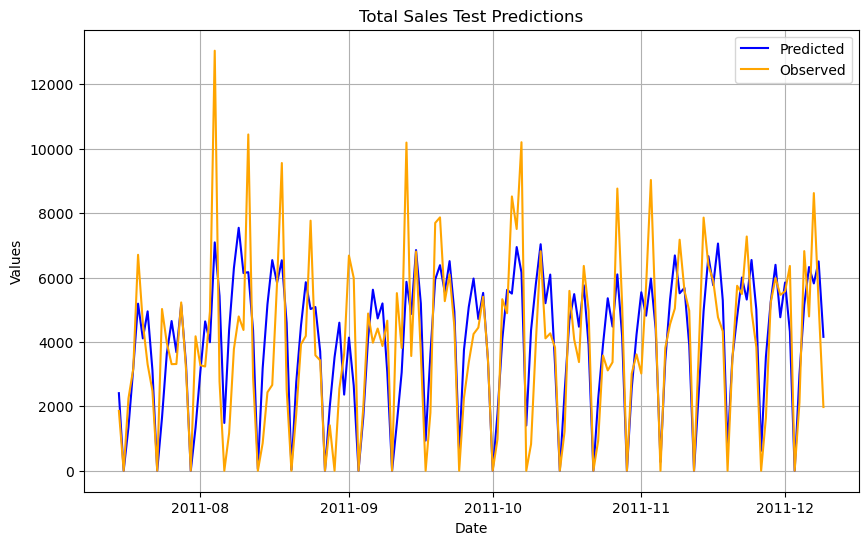

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), best_test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

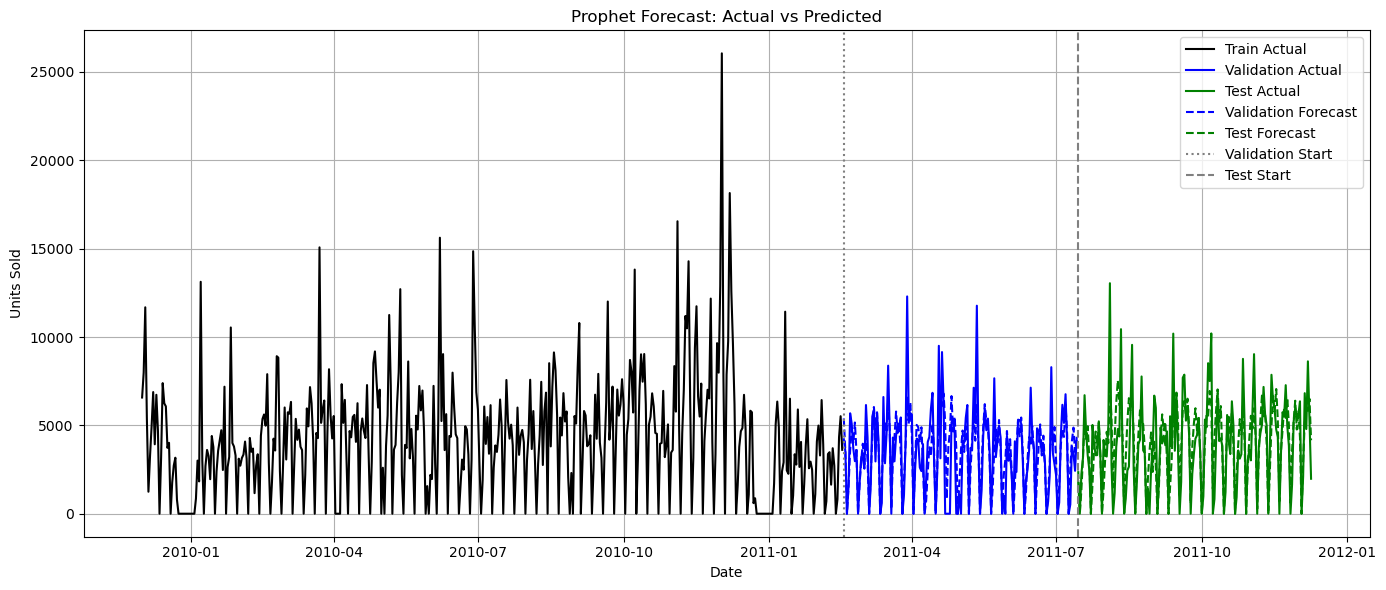

In [51]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(best_validation_forecast['ds'], best_validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(best_test_forecast['ds'], best_test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
